# EP #2 - Harris Corner Detector

Renato Sérgio Lopes Júnior \
2020667570


In [1]:
import cv2
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

## Harris Corner Detector

In [2]:
def get_gradients(img, window_size):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=window_size, borderType=cv2.BORDER_REFLECT)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=window_size, borderType=cv2.BORDER_REFLECT)
    return gx, gy

def create_c_matrix(gx, gy, i, j, window_size):
    C = np.zeros((2, 2))
    # Sum over the neighbourhood
    for k in range(i-int((window_size-1)/2), i+int((window_size-1)/2)+1):
        for l in range(j-int((window_size-1)/2), j+int((window_size-1)/2)+1):
            C[0][0] += gx[k][l]**2
            C[0][1] += gx[k][l]*gy[k][l]
            C[1][0] += gx[k][l]*gy[k][l]
            C[1][1] += gy[k][l]**2
    return C

def check_if_neighbour(corners, i, j, window_size):
    nb_limit = int((window_size-1)/2)
    for corner in corners:
        if corner[0] >= (i-nb_limit) and corner[0] <= (i+nb_limit) and corner[1] >= (j-nb_limit) and corner[1] <= (j+nb_limit):
            return True
    return False

def nms(corners, window_size):
    corners = sorted(corners, key=lambda x: x[0], reverse=True)
    corners_filtered = []
    for corner in corners:
        if not check_if_neighbour(corners_filtered, corner[1], corner[2], window_size):
            corners_filtered.append((corner[1], corner[2]))
    return corners_filtered

def harris(img, threshold, window_size):
    # Add padding to image
    img_pad = cv2.copyMakeBorder(img, window_size-1, window_size-1, window_size-1, window_size-1, cv2.BORDER_REFLECT)
    # Compute gradients
    gx, gy = get_gradients(img_pad, window_size)
    # Find corners
    corners = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            C = create_c_matrix(gx, gy, i, j, window_size)
            U, S, Vt = np.linalg.svd(C, full_matrices=False)
            lambda_2 = S[1]
            if lambda_2 > threshold:
                corners.append((lambda_2, i, j))
    # Remove corners whose neighbourhood overlap
    corners = nms(corners, window_size)
    return corners

## Evaluation

In [3]:
def generate_img():
    img = np.zeros((200, 200, 1), np.uint8)
    corners = [(49, 49), (49, 99), (49, 149), (99, 49), (99, 99), (99, 149), (149, 49), (149, 99), (149, 149)]
    for i in range(4):
        for j in range(i%2, 4, 2):
            img[i*50:(i+1)*50, j*50:(j+1)*50] = [255]
    cv2.imwrite('img.png', img)
    return img, corners

def add_gaussian_noise(img, noise_level):
    row,col,ch= img.shape
    mean = 0
    sigma = noise_level**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = img + gauss
    return noisy.astype(np.uint8)
#     noise = cv2.randn(img.copy(), (0), (255*noise_level))
#     return cv2.add(img, noise)

def draw_corners(img, corners):
    img = img.copy()
    for corner in corners:
        cv2.circle(img, corner, 2, (0,0,255), -1)
    return img

In [4]:
def compute_rms(corners_gt, corners_detected):
    pass

def compute_metrics(corners_gt, corners_detected, threshold=3):
    missed = 0
    for corner_gt in corners_gt:
        found = False
        for corner_detected in corners_detected:
            if (corner_detected[0] >= corner_gt[0]-threshold and corner_detected[0] <= corner_gt[0]+threshold) and (corner_detected[1] >= corner_gt[1]-threshold and corner_detected[1] <= corner_gt[1]+threshold):
                found = True
                break
        if not found:
            missed += 1
    spurious = 0
    for corner_detected in corners_detected:
        found = False
        for corner_gt in corners_gt:
            if (corner_gt[0] >= corner_detected[0]-threshold and corner_gt[0] <= corner_detected[0]+threshold) and (corner_gt[1] >= corner_detected[1]-threshold and corner_gt[1] <= corner_detected[1]+threshold):
                found = True
                break
        if not found:
            spurious += 1
    return missed, spurious

### Generate image

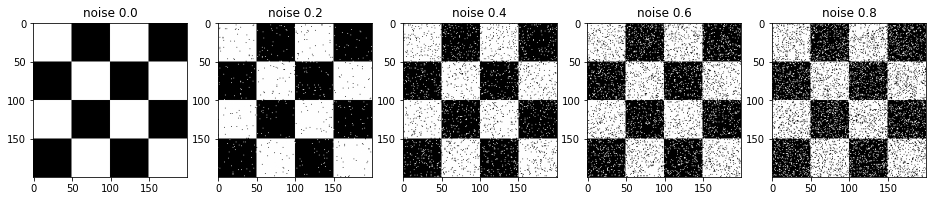

In [5]:
img, corners_gt = generate_img()
img_drawn_gt = draw_corners(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), corners_gt)

i = 1
fig = plt.figure(figsize=(16, 8))
for n in [0.0, 0.2, 0.4, 0.6, 0.8]:
    fig.add_subplot(1, 5, i)
    plt.title(f"noise {n}")
    img_noisy = add_gaussian_noise(img, n)
    plt.imshow(cv2.cvtColor(img_noisy, cv2.COLOR_GRAY2BGR))
    i += 1
plt.show()

### Run detector for different parameter values and noise levels

This will take some time...

In [6]:
results = {}
for threshold, window_size in [(1000, 3), (1000, 5), (1000, 7), (10000, 3), (10000, 5), (10000, 7)]:
    results[(threshold, window_size)] = []
    for noise in [0.0, 0.2, 0.4, 0.6, 0.8]:
        print(f"theshold: {threshold} / window_size: {window_size} / noise: {noise}")
        img_noisy = add_gaussian_noise(img, noise)
        corners = harris(img_noisy, threshold, window_size)
        img_drawn = draw_corners(cv2.cvtColor(img_noisy, cv2.COLOR_GRAY2BGR), corners)
        results[(threshold, window_size)].append((noise, corners, img_drawn))

theshold: 1000 / window_size: 3 / noise: 0.0
theshold: 1000 / window_size: 3 / noise: 0.2
theshold: 1000 / window_size: 3 / noise: 0.4
theshold: 1000 / window_size: 3 / noise: 0.6
theshold: 1000 / window_size: 3 / noise: 0.8
theshold: 1000 / window_size: 5 / noise: 0.0
theshold: 1000 / window_size: 5 / noise: 0.2
theshold: 1000 / window_size: 5 / noise: 0.4
theshold: 1000 / window_size: 5 / noise: 0.6
theshold: 1000 / window_size: 5 / noise: 0.8
theshold: 1000 / window_size: 7 / noise: 0.0
theshold: 1000 / window_size: 7 / noise: 0.2
theshold: 1000 / window_size: 7 / noise: 0.4
theshold: 1000 / window_size: 7 / noise: 0.6
theshold: 1000 / window_size: 7 / noise: 0.8
theshold: 10000 / window_size: 3 / noise: 0.0
theshold: 10000 / window_size: 3 / noise: 0.2
theshold: 10000 / window_size: 3 / noise: 0.4
theshold: 10000 / window_size: 3 / noise: 0.6
theshold: 10000 / window_size: 3 / noise: 0.8
theshold: 10000 / window_size: 5 / noise: 0.0
theshold: 10000 / window_size: 5 / noise: 0.2
the

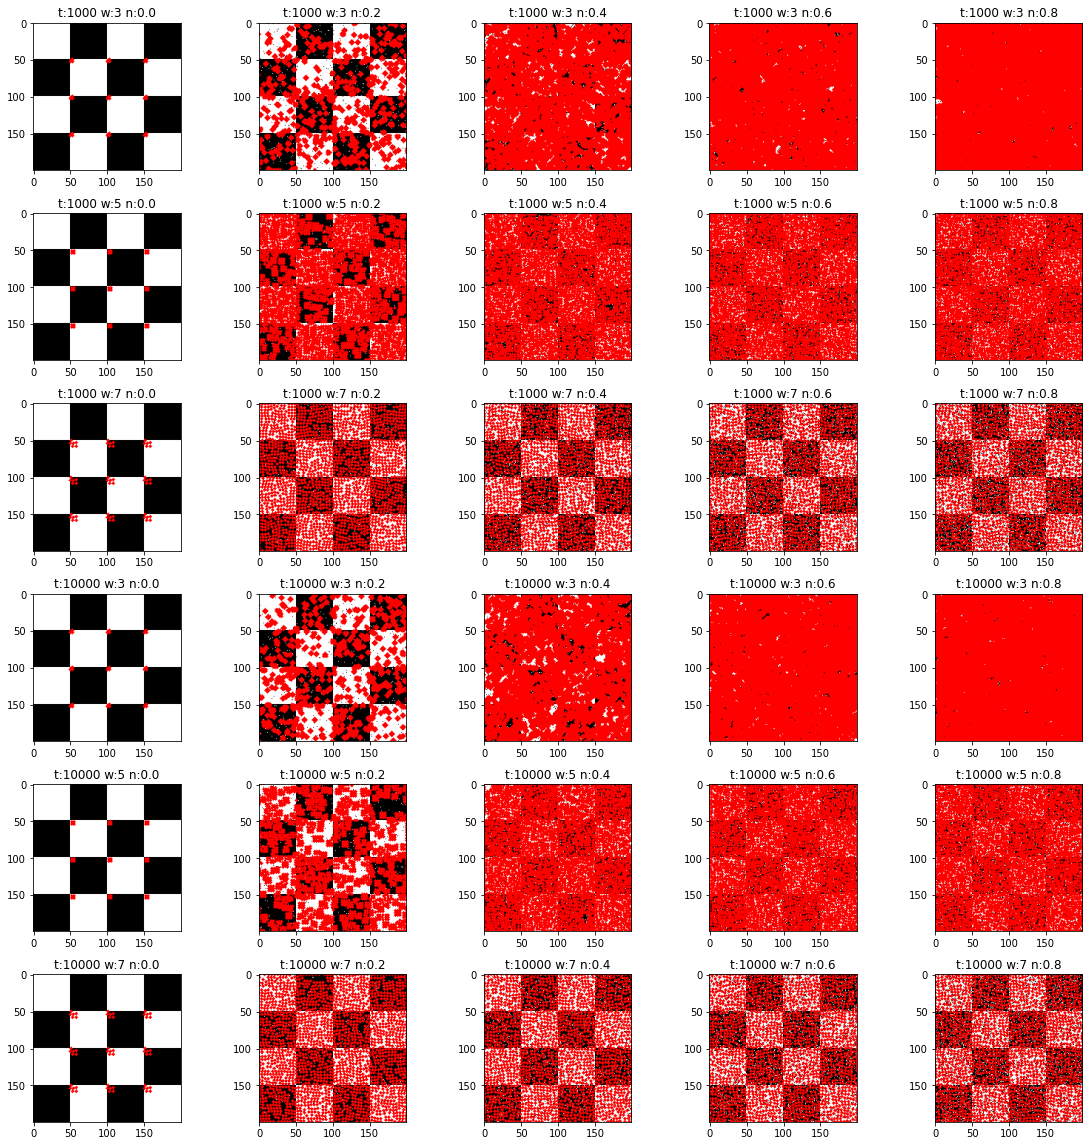

In [7]:
fig = plt.figure(figsize=(16, 16))
i = 1
for key in results.keys():
    result = results[key]
    for r in result:
        fig.add_subplot(6, 5, i)
        plt.title(f"t:{key[0]} w:{key[1]} n:{r[0]}")
        plt.imshow(cv2.cvtColor(r[2], cv2.COLOR_BGR2RGB))
        i += 1
plt.tight_layout(pad=1.0)
plt.show()

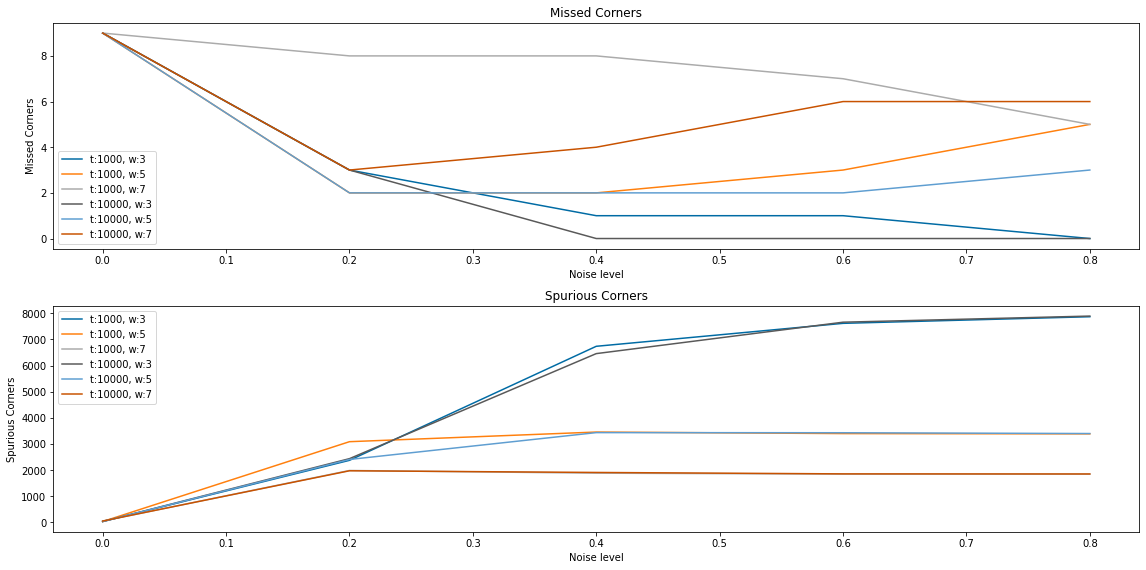

In [8]:
missed = {}
spurious = {}
for key in results.keys():
    result = results[key]
    missed[key] = []
    spurious[key] = []
    for r in result:
        m, s = compute_metrics(corners_gt, r[1], 1)
        missed[key].append((r[0], m))
        spurious[key].append((r[0], s))
        
plt.figure(figsize=(16, 8))
plt.subplot(2, 1, 1)
for key in missed.keys():
    m = np.array(missed[key])
    plt.plot(m[:, 0], m[:, 1], label=f"t:{key[0]}, w:{key[1]}")
plt.legend()
plt.xlabel('Noise level')
plt.ylabel('Missed Corners')
plt.title('Missed Corners')

plt.subplot(2, 1, 2)
for key in missed.keys():
    s = np.array(spurious[key])
    plt.plot(s[:, 0], s[:, 1], label=f"t:{key[0]}, w:{key[1]}")
plt.legend()
plt.xlabel('Noise level')
plt.ylabel('Spurious Corners')
plt.title('Spurious Corners')

plt.tight_layout(pad=1.0)
plt.show()

### Comparing with cv2.cornerHarris

theshold: 1000 / window_size: 3 / noise: 0.0
theshold: 1000 / window_size: 3 / noise: 0.2
theshold: 1000 / window_size: 3 / noise: 0.4
theshold: 1000 / window_size: 3 / noise: 0.6
theshold: 1000 / window_size: 3 / noise: 0.8
theshold: 1000 / window_size: 5 / noise: 0.0
theshold: 1000 / window_size: 5 / noise: 0.2
theshold: 1000 / window_size: 5 / noise: 0.4
theshold: 1000 / window_size: 5 / noise: 0.6
theshold: 1000 / window_size: 5 / noise: 0.8
theshold: 1000 / window_size: 7 / noise: 0.0
theshold: 1000 / window_size: 7 / noise: 0.2
theshold: 1000 / window_size: 7 / noise: 0.4
theshold: 1000 / window_size: 7 / noise: 0.6
theshold: 1000 / window_size: 7 / noise: 0.8
theshold: 10000 / window_size: 3 / noise: 0.0
theshold: 10000 / window_size: 3 / noise: 0.2
theshold: 10000 / window_size: 3 / noise: 0.4
theshold: 10000 / window_size: 3 / noise: 0.6
theshold: 10000 / window_size: 3 / noise: 0.8
theshold: 10000 / window_size: 5 / noise: 0.0
theshold: 10000 / window_size: 5 / noise: 0.2
the

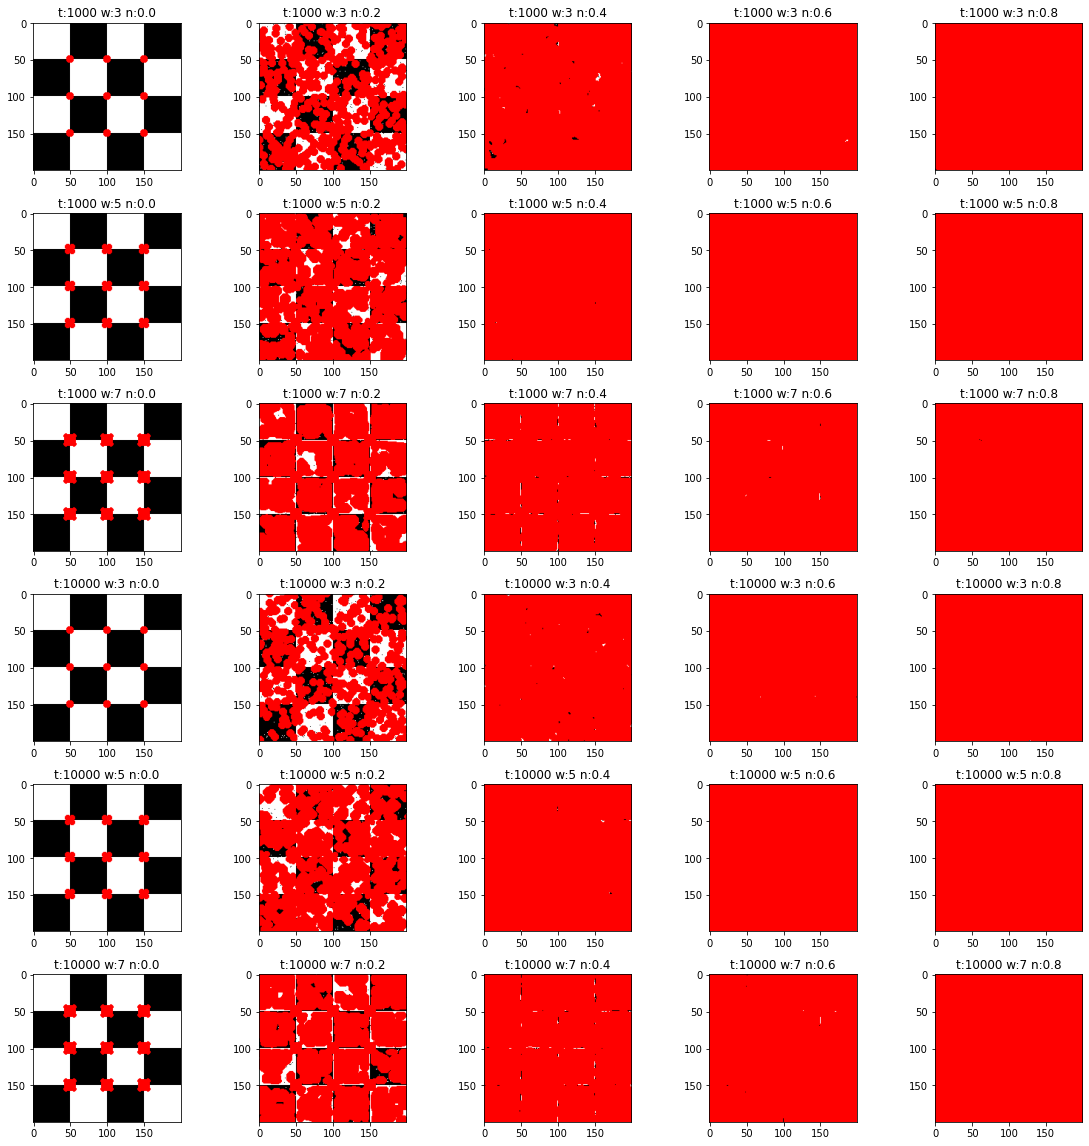

In [9]:
results_cv2 = {}
for threshold, window_size in [(1000, 3), (1000, 5), (1000, 7), (10000, 3), (10000, 5), (10000, 7)]:
    results_cv2[(threshold, window_size)] = []
    for noise in [0.0, 0.2, 0.4, 0.6, 0.8]:
        print(f"theshold: {threshold} / window_size: {window_size} / noise: {noise}")
        img_noisy = add_gaussian_noise(img, noise)
        
        dst = cv2.cornerHarris(np.float32(img_noisy), window_size, window_size, 0.04)
        dst = cv2.dilate(dst,None)
        
        corners = []
        for i in range(dst.shape[0]):
            for j in range(dst.shape[1]):
                if dst[i][j] >= threshold:
                    corners.append((i, j))
        img_drawn = draw_corners(cv2.cvtColor(img_noisy, cv2.COLOR_GRAY2BGR), corners)
        results_cv2[(threshold, window_size)].append((noise, corners, img_drawn))

fig = plt.figure(figsize=(16, 16))
i = 1
for key in results_cv2.keys():
    result = results_cv2[key]
    for r in result:
        fig.add_subplot(6, 5, i)
        plt.title(f"t:{key[0]} w:{key[1]} n:{r[0]}")
        plt.imshow(cv2.cvtColor(r[2], cv2.COLOR_BGR2RGB))
        i += 1
plt.tight_layout(pad=1.0)
plt.show()